# Introduction

## Import the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('winemag-data.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


In [4]:
df.isna().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

## Data Cleaning
The one missing variety will be removed from the data as there will be no affect on the model performance for one less item. The 'Unnamed: 0 column will be dropped as it is just an index. 

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)
#df = df.dropna(subset=['variety'])
df.isna().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

## Data Exploration

1. What are the largest produced varities? Highest price? highest reviewed?
2. Which countries and regions produce the largest quantities of wine? highest priced? highest reviews?
3. What are the most common descriptor words in the reviews? 
4. Which tasters has reviewed more wine? what is the spread of their reviews?
5. Which winery is considered the best per variety?

### Variety

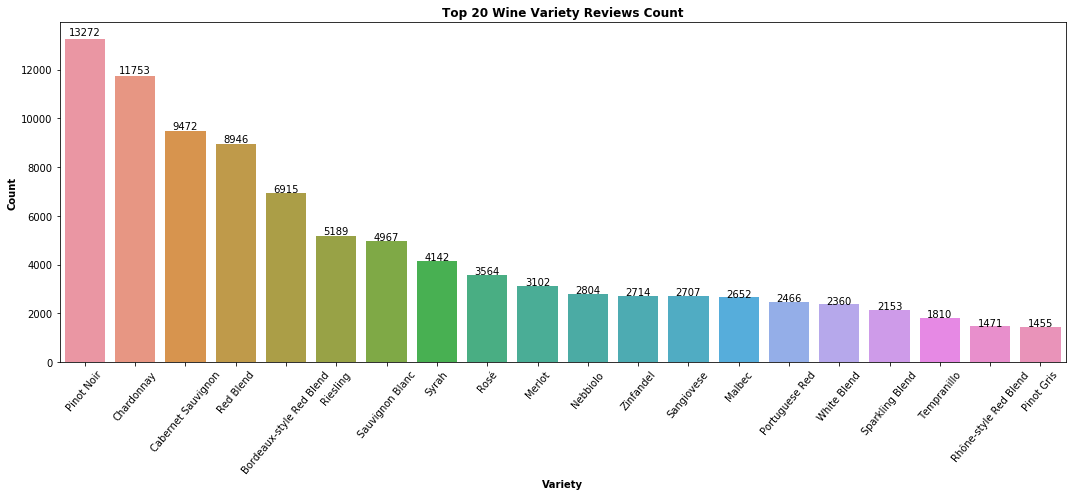

In [6]:
plt.figure(figsize=(15, 7))

# Plot the chart of top 20 varities
graph = sns.countplot(x=df['variety'], 
            order=df['variety'].value_counts().iloc[:20].index)

# Add count total for each bar
for i, p in enumerate(graph.patches):
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height*1.01,
        df['variety'].value_counts()[i], ha="center")

plt.title('Top 20 Wine Variety Reviews Count', fontweight='bold')
plt.xlabel('Variety', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [7]:
variety_largest = df['variety'].value_counts().nlargest(20).reset_index()
variety_largest = variety_largest['index']

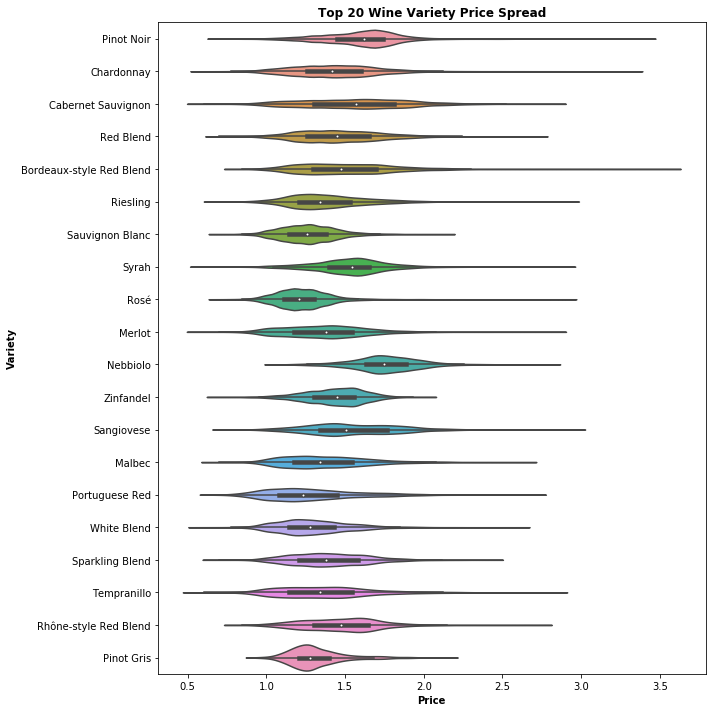

In [8]:
variety_index = df.set_index('variety')
variety_index = variety_index.loc[variety_largest].reset_index()

plt.figure(figsize=(10, 10))
sns.violinplot(x=np.log10(variety_index['price']), 
               y=variety_index['variety'])

plt.title('Top 20 Wine Variety Price Spread', fontweight='bold')
plt.ylabel('Variety', fontweight='bold')
plt.xlabel('Price', fontweight='bold')


plt.tight_layout()
plt.show()

In [9]:
variety_index.groupby('variety')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
variety,,,,,,,,
Bordeaux-style Red Blend,5340.0,47.210861,92.810629,7.0,19.75,30.0,50.0,3300.0
Cabernet Sauvignon,9386.0,47.940017,41.157236,4.0,20.00,37.0,65.0,625.0
Chardonnay,11080.0,34.522022,42.245055,4.0,18.00,26.0,40.0,2013.0
Malbec,2593.0,29.926726,26.745024,5.0,15.00,22.0,35.0,400.0
Merlot,3062.0,29.543436,33.340882,4.0,15.00,24.0,35.0,625.0
Nebbiolo,2331.0,65.609610,42.919491,12.0,43.00,56.0,77.0,595.0
Pinot Gris,1391.0,23.074047,13.712080,9.0,16.00,19.0,25.0,135.0
Pinot Noir,12787.0,47.528897,47.609434,5.0,28.00,42.0,55.0,2500.0
Portuguese Red,2196.0,24.819217,25.539475,5.0,12.00,17.0,28.0,450.0


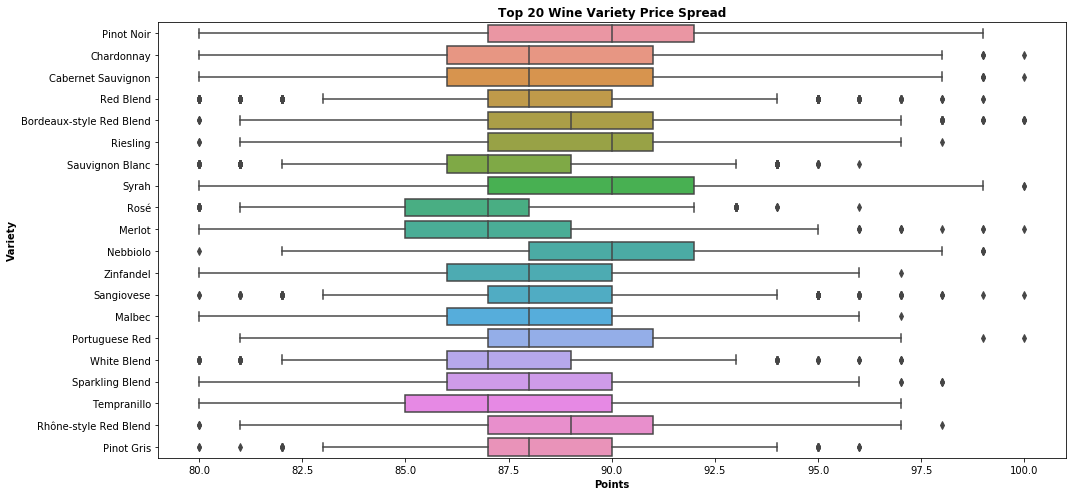

In [10]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=variety_index['points'], y=variety_index['variety'])

plt.title('Top 20 Wine Variety Price Spread', fontweight='bold')
plt.ylabel('Variety', fontweight='bold')
plt.xlabel('Points', fontweight='bold')


plt.tight_layout()
plt.show()

### Countries and Regions

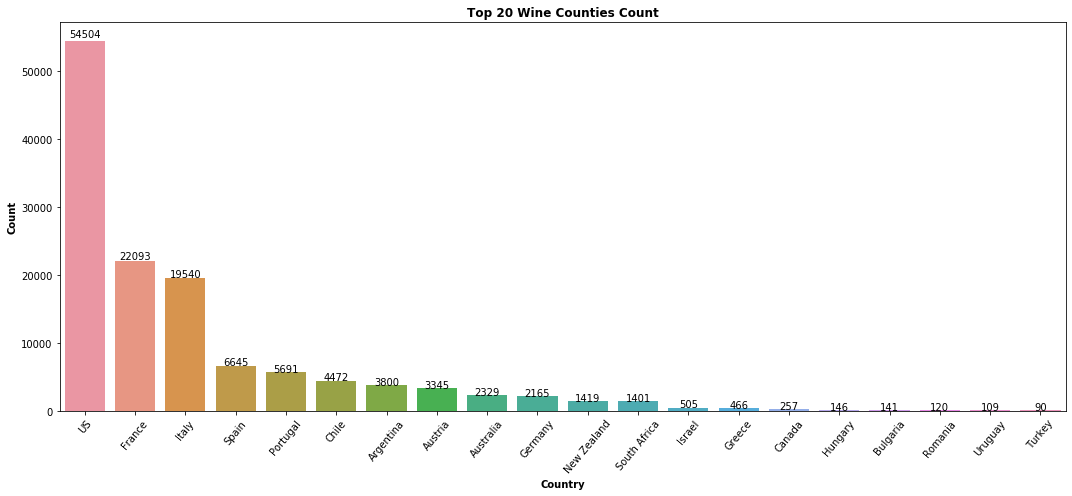

In [11]:
plt.figure(figsize=(15, 7))

# Plot the chart of top 20 varities
graph = sns.countplot(x=df['country'], 
                order=df['country'].value_counts().iloc[:20].index)

# Add count total for each bar
for i, p in enumerate(graph.patches):
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height*1.01,
        df['country'].value_counts()[i], ha="center")

plt.title('Top 20 Wine Counties Count', fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [12]:
country_largest = df['country'].value_counts().nlargest(10).reset_index()
country_largest = country_largest['index']

country_index = df.set_index('country')
country_index = country_index.loc[country_largest].reset_index()

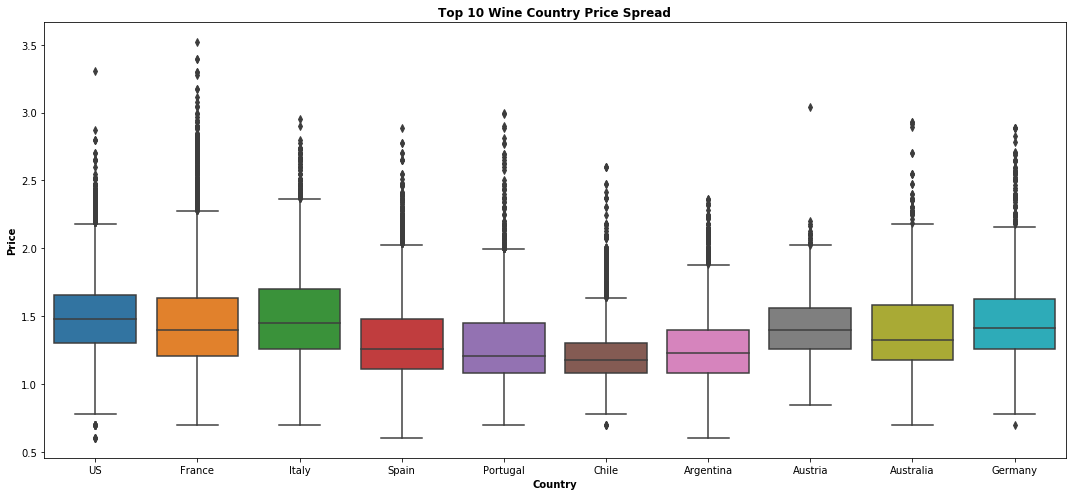

In [13]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=country_index['country'], y=np.log10(country_index['price']))

plt.title('Top 10 Wine Country Price Spread', fontweight='bold')
plt.ylabel('Price', fontweight='bold')
plt.xlabel('Country', fontweight='bold')


plt.tight_layout()
plt.show()

In [14]:
country_avg = df.groupby('country')['price'].mean()
print('Higest Average Bottle Price per Country',country_avg.nlargest(10))
print('\nCheapest Average Bottle Price per Country',country_avg.nsmallest(10))

Higest Average Bottle Price per Country country
Switzerland    85.285714
England        51.681159
Germany        42.257547
France         41.139120
Hungary        40.648276
Italy          39.663770
US             36.573464
Canada         35.712598
Australia      35.437663
Israel         31.768916
Name: price, dtype: float64

Cheapest Average Bottle Price per Country country
Ukraine                    9.214286
Bosnia and Herzegovina    12.500000
India                     13.333333
Armenia                   14.500000
Bulgaria                  14.645390
Romania                   15.241667
Macedonia                 15.583333
Slovakia                  16.000000
Cyprus                    16.272727
Moldova                   16.745763
Name: price, dtype: float64


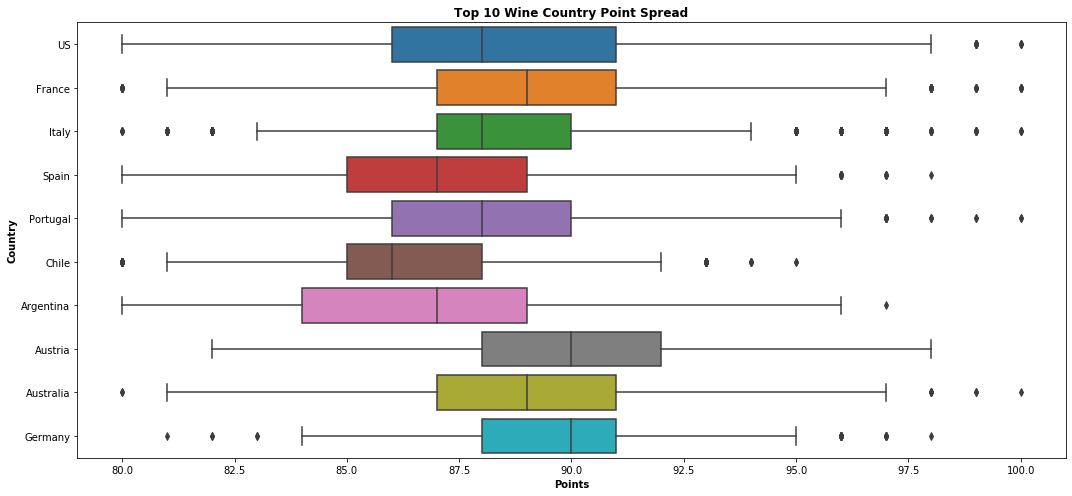

In [15]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=country_index['points'], y=country_index['country'])

plt.title('Top 10 Wine Country Point Spread', fontweight='bold')
plt.ylabel('Country', fontweight='bold')
plt.xlabel('Points', fontweight='bold')


plt.tight_layout()
plt.show()

In [16]:
country_avg = df.groupby('country')['points'].mean()
print('Higest Average Bottle Points per Country',country_avg.nlargest(10))
print('\nLowest Average Bottle Points per Country',country_avg.nsmallest(10))

Higest Average Bottle Points per Country country
England       91.581081
India         90.222222
Austria       90.101345
Germany       89.851732
Canada        89.369650
Hungary       89.191781
China         89.000000
France        88.845109
Luxembourg    88.666667
Australia     88.580507
Name: points, dtype: float64

Lowest Average Bottle Points per Country country
Peru                      83.562500
Egypt                     84.000000
Ukraine                   84.071429
Brazil                    84.673077
Mexico                    85.257143
Romania                   86.400000
Chile                     86.493515
Bosnia and Herzegovina    86.500000
Argentina                 86.710263
Uruguay                   86.752294
Name: points, dtype: float64


### Points


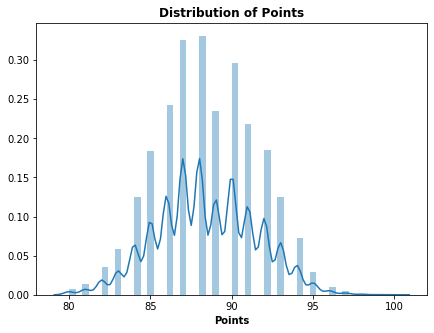

Average Points: 88.44713820775404


In [17]:
#plt.figure(figsize=(15,7))
plt.figure(figsize=(7, 5))
sns.distplot(df['points'])

plt.title('Distribution of Points', fontweight='bold')
plt.xlabel('Points', fontweight='bold')

plt.show()

avg_points = df['points'].mean()
print('Average Points: {}'.format(avg_points))

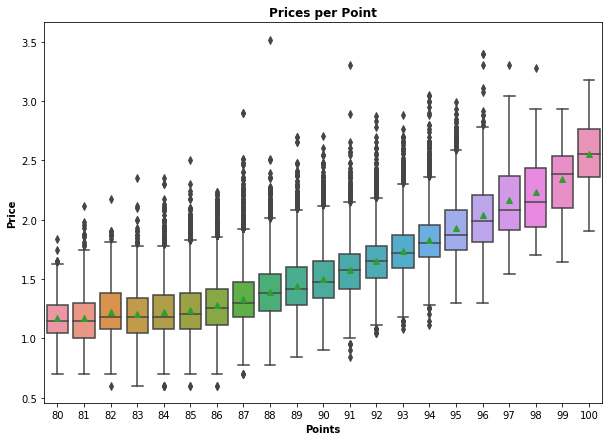

In [18]:
plt.figure(figsize=(10, 7))

sns.boxplot(x=df['points'], y=np.log10(df['price']), showmeans=True)

plt.title('Prices per Point', fontweight='bold')
plt.ylabel('Price', fontweight='bold')
plt.xlabel('Points', fontweight='bold')

plt.show()

In [19]:
score_price = df.groupby('points')['price'].mean()
print(score_price.sort_values(ascending=False))

points
100    485.947368
99     284.214286
98     245.492754
97     207.173913
96     159.292531
95     109.235420
94      81.436938
93      63.112216
92      51.037763
91      43.224252
90      36.906622
89      32.169640
88      28.687523
87      24.901884
86      22.133759
85      19.949562
84      19.310215
82      18.870767
83      18.237353
81      17.182353
80      16.372152
Name: price, dtype: float64


# Bottles

In [20]:
df['title'].value_counts().nlargest(10)

Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)                11
Korbel NV Brut Sparkling (California)                                  9
Segura Viudas NV Extra Dry Sparkling (Cava)                            8
Gloria Ferrer NV Blanc de Noirs Sparkling (Carneros)                   7
Segura Viudas NV Aria Estate Extra Dry Sparkling (Cava)                7
Ruinart NV Brut Rosé  (Champagne)                                      7
J Vineyards & Winery NV Brut Rosé Sparkling (Russian River Valley)     6
Boizel NV Brut Réserve  (Champagne)                                    6
Pierre Sparr NV Brut Réserve Sparkling (Crémant d'Alsace)              6
Bailly-Lapierre NV Brut  (Crémant de Bourgogne)                        6
Name: title, dtype: int64

In [21]:
avg_bottle = df['title'].value_counts().mean()

print('Average Number Reviews per Bottle: {}'.format(
    round(avg_bottle, 2)))

Average Number Reviews per Bottle: 1.09


In [22]:
top_bottles = df.sort_values(by='price', ascending=False)

top_bottles[['title', 'variety', 'winery', 'price', 'points', 'country']].head(10)

,title,variety,winery,price,points,country
80290,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet,3300.0,88,France
15840,Château Pétrus 2014 Pomerol,Bordeaux-style Red Blend,Château Pétrus,2500.0,96,France
98380,Domaine du Comte Liger-Belair 2010 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2500.0,96,France
120391,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...,Chardonnay,Blair,2013.0,91,US
113564,Domaine du Comte Liger-Belair 2005 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2000.0,96,France
65352,Château Pétrus 2011 Pomerol,Bordeaux-style Red Blend,Château Pétrus,2000.0,97,France
1558,Château Margaux 2009 Margaux,Bordeaux-style Red Blend,Château Margaux,1900.0,98,France
111753,Château Lafite Rothschild 2010 Pauillac,Bordeaux-style Red Blend,Château Lafite Rothschild,1500.0,100,France
111755,Château Cheval Blanc 2010 Saint-Émilion,Bordeaux-style Red Blend,Château Cheval Blanc,1500.0,100,France
1575,Château Mouton Rothschild 2009 Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild,1300.0,96,France


## Wineries

In [23]:
winery_largest = df['winery'].value_counts().nlargest(10).reset_index()
winery_largest = winery_largest['index']

winery_index = df.set_index('winery')
winery_index = winery_index.loc[winery_largest].reset_index()

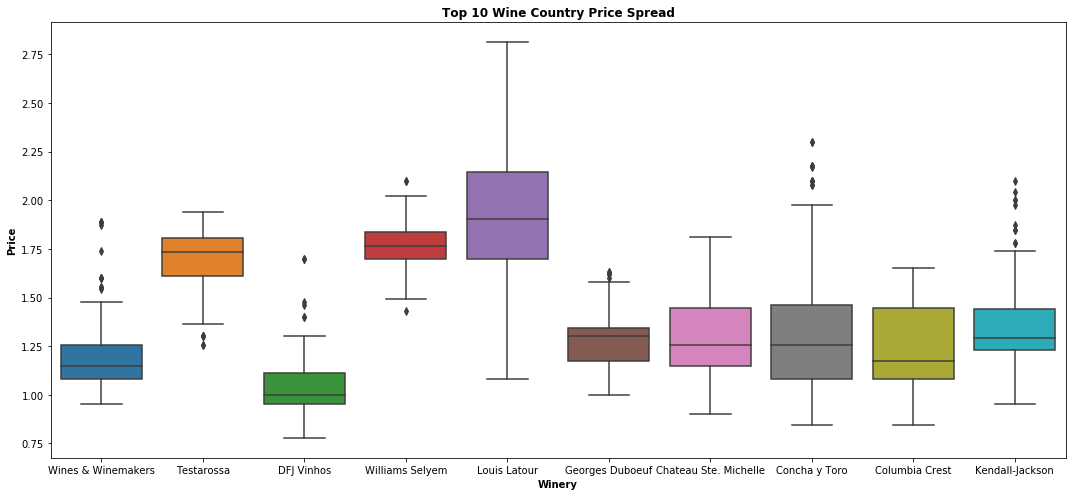

In [24]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=winery_index['winery'], y=np.log10(winery_index['price']))

plt.title('Top 10 Wine Country Price Spread', fontweight='bold')
plt.ylabel('Price', fontweight='bold')
plt.xlabel('Winery', fontweight='bold')


plt.tight_layout()
plt.show()

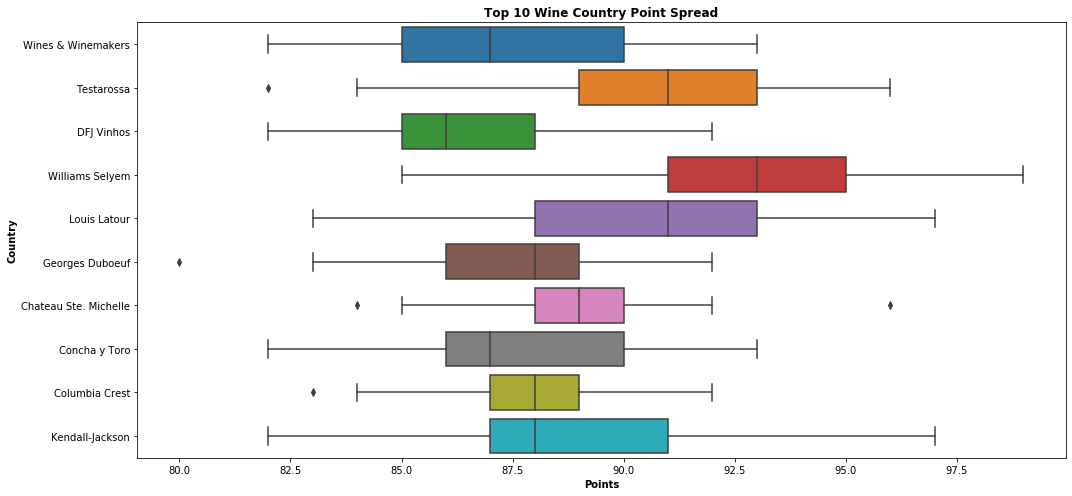

In [25]:
plt.figure(figsize=(15, 7))
sns.boxplot(x=winery_index['points'], y=winery_index['winery'])

plt.title('Top 10 Wine Country Point Spread', fontweight='bold')
plt.ylabel('Country', fontweight='bold')
plt.xlabel('Points', fontweight='bold')


plt.tight_layout()
plt.show()

## Tasters

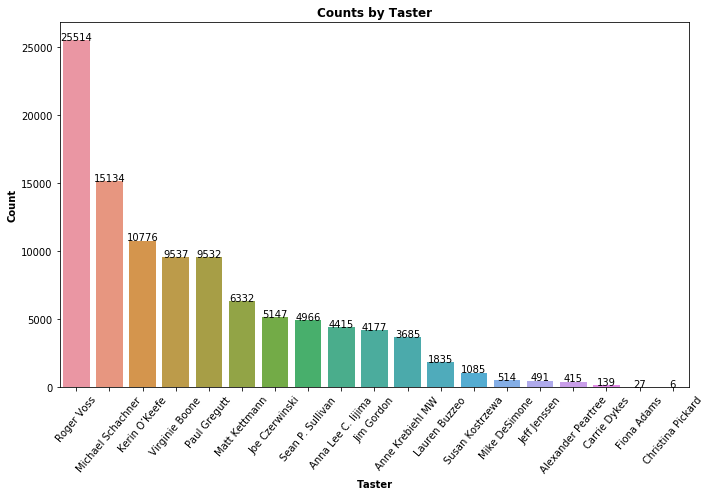

In [26]:
plt.figure(figsize=(10, 7))

# Plot the chart of Tasters
graph = sns.countplot(x=df['taster_name'], 
                      order=df['taster_name'].value_counts().index)

# Add count total for each bar
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        df['taster_name'].value_counts()[i],ha="center")
    i += 1

plt.title('Counts by Taster', fontweight='bold')
plt.xlabel('Taster', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

In [27]:
print(df['points'].describe())
print('\n', df.groupby('taster_name')['points'].mean())

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

 taster_name
Alexander Peartree    85.855422
Anna Lee C. Iijima    88.415629
Anne Krebiehl MW      90.562551
Carrie Dykes          86.395683
Christina Pickard     87.833333
Fiona Adams           86.888889
Jeff Jenssen          88.319756
Jim Gordon            88.626287
Joe Czerwinski        88.536235
Kerin O’Keefe         88.867947
Lauren Buzzeo         87.739510
Matt Kettmann         90.008686
Michael Schachner     86.907493
Mike DeSimone         89.101167
Paul Gregutt          89.082564
Roger Voss            88.708003
Sean P. Sullivan      88.755739
Susan Kostrzewa       86.609217
Virginie Boone        89.213379
Name: points, dtype: float64


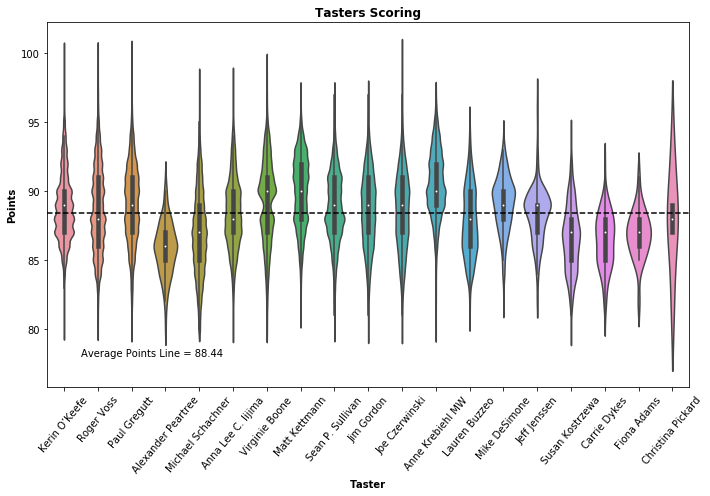

In [28]:
plt.figure(figsize=(10, 7))

sns.violinplot(x=df['taster_name'], y=df['points'])

plt.axhline(df['points'].mean(), color='black', ls='--')
plt.text(0.5,78, 'Average Points Line = 88.44')

plt.title('Tasters Scoring', fontweight='bold')
plt.xlabel('Taster', fontweight='bold')
plt.ylabel('Points', fontweight='bold')

plt.xticks(rotation=50)
plt.tight_layout()
plt.show()

## Year

In [29]:
df['year'] = df['title'].apply(lambda x: ''.join(list(filter(str.isdigit, str(x)))))

years = []
for year in df['year']:
    year = ''.join(year[:4])
    years.append(year)
        
df['year'] = years
df['year'] = pd.to_numeric(df['year'], errors='coerce')

mask = df['year'] > 2017
column_name = 'year'
df.loc[mask, column_name] = None

mask = df['year'] < 1990
df.loc[mask, column_name] = None


df['year'].describe()

count    124404.000000
mean       2010.695347
std           3.547489
min        1990.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2017.000000
Name: year, dtype: float64

In [30]:
df['year'].isna().sum()

5567

In [31]:
df['year'] = df['year'].fillna(df['year'].mean())
df['year'] = round(df['year'])
df['year'].isna().sum()

0

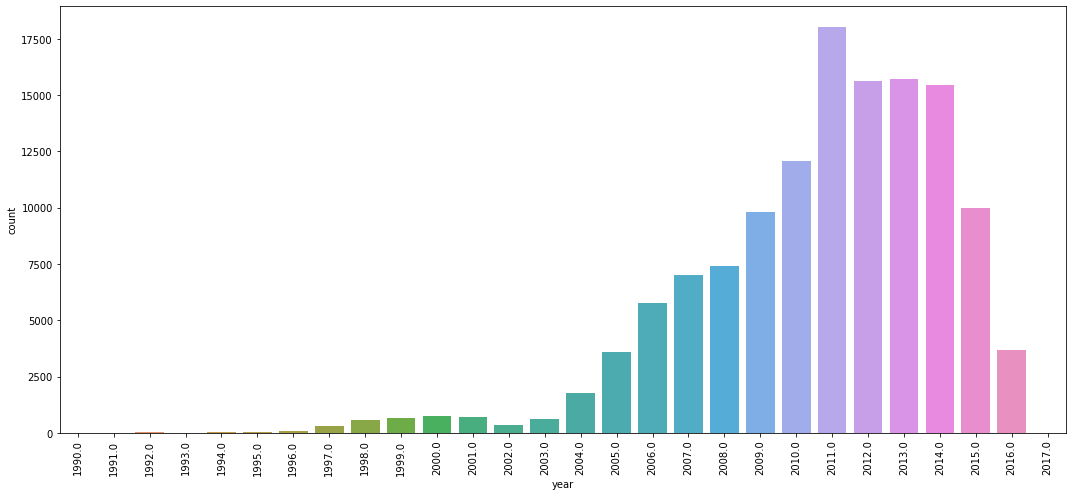

In [32]:
plt.figure(figsize=(15, 7))

graph = sns.countplot(df['year'])

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

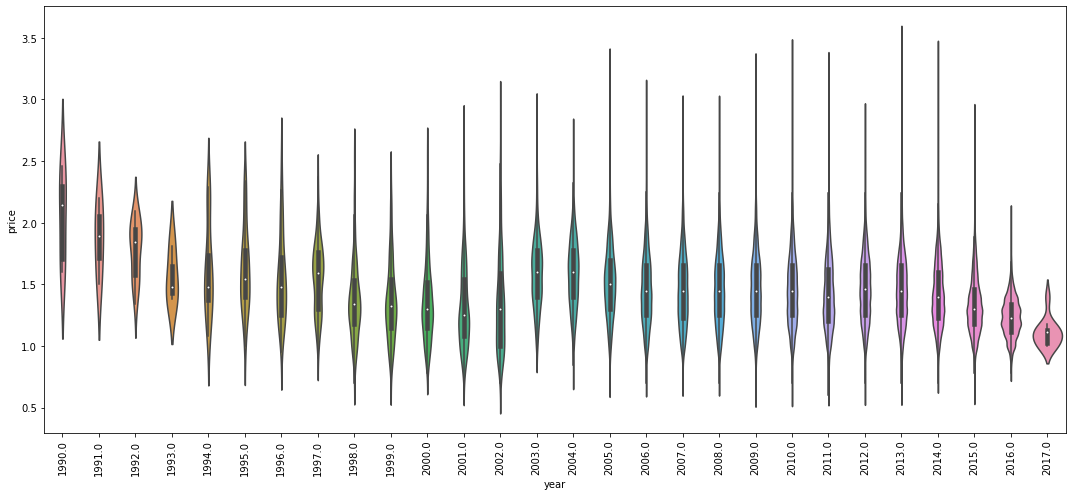

In [33]:
plt.figure(figsize=(15, 7))

sns.violinplot(x=df['year'], y=np.log10(df['price']))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

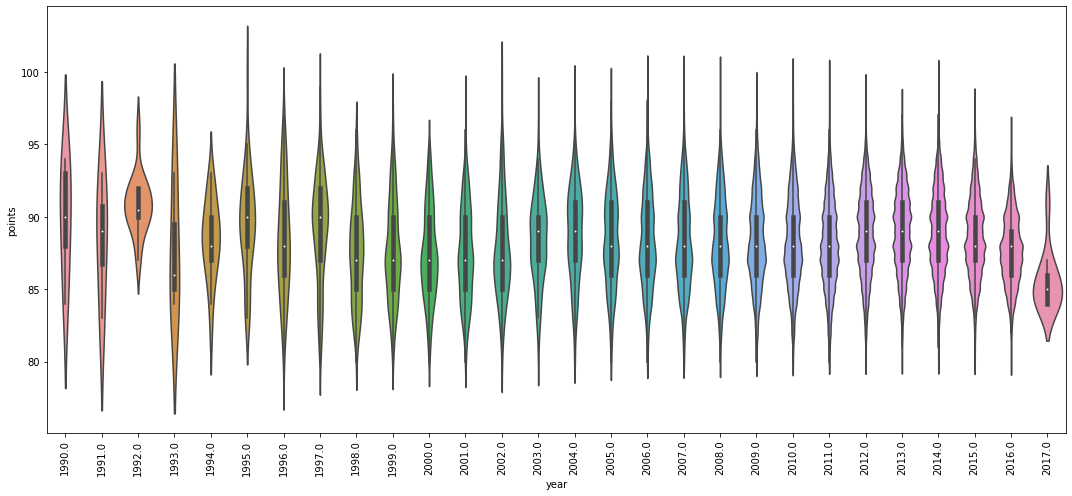

In [34]:
plt.figure(figsize=(15, 7))

sns.violinplot(x=df['year'], y=df['points'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Description

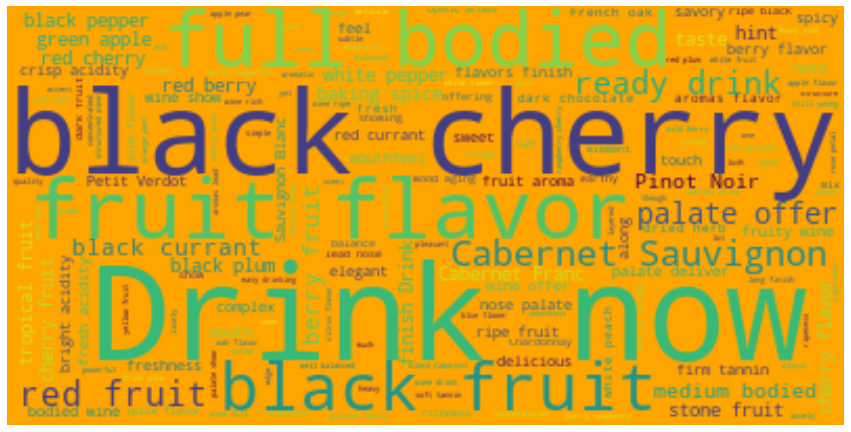

In [35]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='orange').generate(
            ''.join(df['description']))

plt.figure(figsize=(15, 10))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

for punc in [',','.',"'"]:
    df['description'] = df['description'].str.replace(punc, '')

df['description'] = df['description'].apply(lambda x: str.lower(x))    
    
df['description'].head()

In [36]:
word_count = df['description'].apply(lambda x: len(str(x).split(' ')))
word_count.describe()

count    129971.000000
mean         40.384440
std          11.113601
min           3.000000
25%          33.000000
50%          39.000000
75%          47.000000
max         135.000000
Name: description, dtype: float64

#### Description Cleaning


In [37]:
pd.Series(''.join(df['description']
                 ).split()).value_counts().nlargest(10)


and     346934
of      172822
the     168168
a       157462
with    115572
is       96234
this     72467
in       59654
wine     55985
to       55263
dtype: int64

In [38]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

# Create a list of stop words
stop_words = set(stopwords.words('english'))

In [41]:
corpus = []
for i in range(0, word_count.count()):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df['description'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text = re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps = PorterStemmer()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

#### Creating Vector of Word Counts

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

# CV 
cv = CountVectorizer(max_df=.8, stop_words=stop_words,
                    max_features=1000, ngram_range=(1, 3))

X = cv.fit_transform(corpus)

list(cv.vocabulary_.keys())[:10]

['aroma',
 'include',
 'tropical',
 'fruit',
 'dried',
 'herb',
 'palate',
 'offering',
 'apple',
 'citrus']

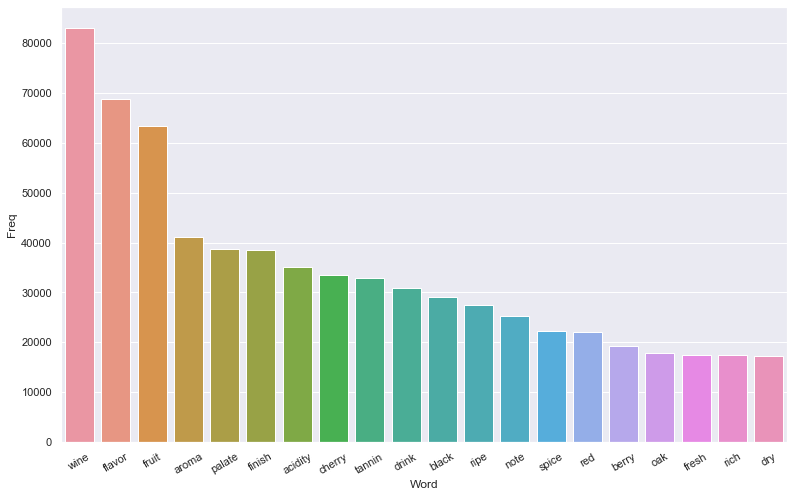

In [43]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words


sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show()

               Bi-gram  Freq
0         black cherry  8861
1         fruit flavor  7982
2          full bodied  6932
3          black fruit  5608
4   cabernet sauvignon  5259
5            red fruit  4656
6          ready drink  4308
7         palate offer  4256
8        black currant  3778
9          berry fruit  3763
10           red berry  3599
11       medium bodied  3399
12          pinot noir  3221
13          red cherry  2932
14        black pepper  2879
15         stone fruit  2641
16        white pepper  2591
17         green apple  2573
18      tropical fruit  2513
19          black plum  2474


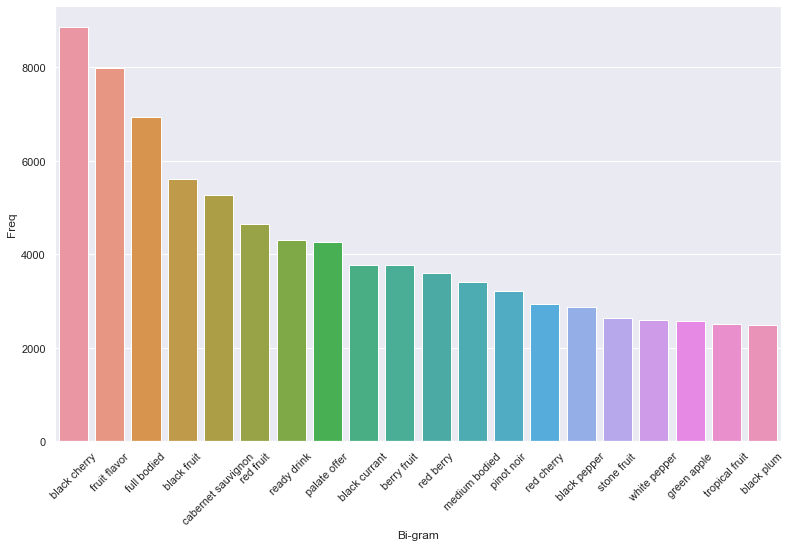

In [44]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)
plt.show()

                       Tri-gram  Freq
0           fine grained tannin  1126
1      blend cabernet sauvignon  1116
2              full bodied wine  1110
3     cabernet sauvignon merlot  1020
4              wine ready drink   983
5               red berry fruit   932
6            black fruit flavor   883
7                new french oak   801
8            dried black cherry   717
9            medium bodied wine   708
10    merlot cabernet sauvignon   662
11          black currant fruit   662
12            ripe black cherry   634
13           black cherry fruit   625
14             red fruit flavor   622
15        merlot cabernet franc   574
16           palate offer dried   528
17     blackberry black currant   524
18  cabernet sauvignon cabernet   470
19           full bodied palate   470


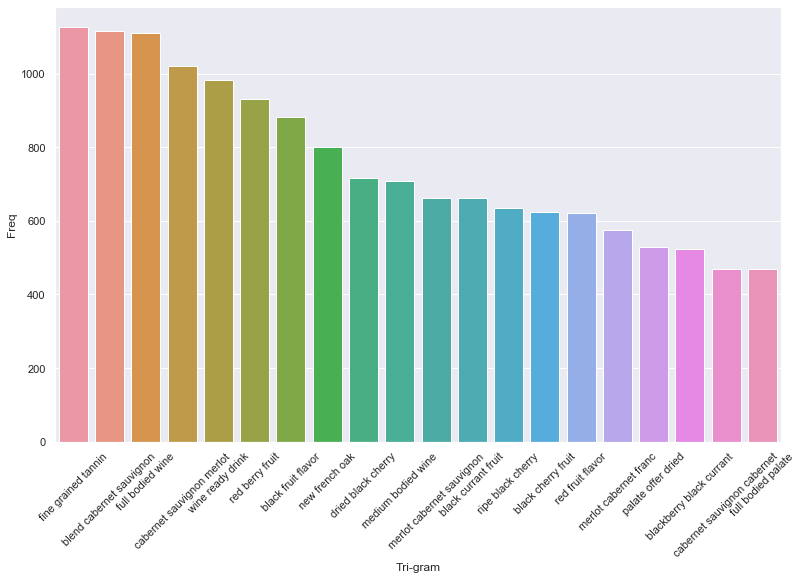

In [45]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)
plt.show()

In [46]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[1]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [47]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
ripe fruity wine smooth still structured firm tannin filled juicy red berry fruit freshened acidity already drinkable although certainly better

Keywords:
drinkable 0.295
certainly 0.294
red berry fruit 0.292
better 0.266
fruity wine 0.257


In [48]:
print(keywords)

{'drinkable': 0.295, 'certainly': 0.294, 'red berry fruit': 0.292, 'better': 0.266, 'fruity wine': 0.257}


In [49]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names

feature_names=cv.get_feature_names()
 


In [51]:
# fetch document for which keywords needs to be extracted
def keyword_gen(description):
    keyword_list = {}
    
    for words in description:
        # fetch document for which keywords needs to be extracted
        doc = words
 
        #generate tf-idf for the given document
        tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
         
        #sort the tf-idf vectors by descending order of scores
        sorted_items = sort_coo(tf_idf_vector.tocoo())
        #extract only the top n; n here is 10
        keywords = extract_topn_from_vector(feature_names,sorted_items,5)
        
        keyword_list.update(keywords)
        
    keyword_list = list(keyword_list.keys())
    temp_list = []
    
    for word in keyword_list:
        if word not in temp_list:
            temp_list.append(word)
    
    
    print('There are {} keywords.'.format(len(temp_list)))
    return temp_list

In [52]:
keywords = keyword_gen(corpus)

There are 1000 keywords.


In [55]:
def keyword_dummies(keyword):
    n_words = len(keywords)
    return dict(zip(keywords, [1]*n_words))

df_dummies = pd.DataFrame(list(df['description'].apply(keyword_dummies).values)).fillna(0)
df_dummies.head()

,accent,accented,accessible,acid,acidic,acidity,acidity drink,acidity finish,acidity give,acidity wine,...,yellow apple,yellow fruit,yet,young,young wine,youthful,zest,zesty,zin,zinfandel
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
